<h1> SGWB Figure of Merits</h1> 

In the following, we'll implement a notebook that, given the required Probability Distribution Functions (PDF) describing a Black Hole population(BH), generates the figure of merit for the predicted analytical Stochastic Gravitational Wave Background(SGWB) in function of the amplitude and redshift range of the merging rate.
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

SOBBH = False
SOBBH_Redevol = False
SOBBH_RSpike = False

# Merger distribution parameters

T_obs = 6. # Lisa estimated years of observation
efficiency = 0.75 # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_star = 1.e-2 # Value of the choosen frequency at which we estimate the SGWB to compare with other results

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
GPc = 3.08567758149137*1e25 # meters
h = 0.678
H_0 = 67.8/(3.086e+19) # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 10
frq_res = 1e-6
frq_prec = int((frq_max - frq_min)/frq_res) + 1

# Variable specific for the SOBBH case

SOBBH_massprec = 500           # Binning density for the masses
SOBBH_zprec = 500              # Binning density for the redshift (affect distance density)


<h2> FLAG selection section </h2>

To begin, we have to decide which types of sources we wish to simulate in our SGWB :

In [3]:
SOBBH = True # If true, add the total SGWB strain produced by stellar origin binary black hole merging on the strain as estimated by LIGO

We may also decide to simulate the catalogue with a redshift evolving merging rate, by setting to true the Red_evol flag:

In [4]:
#SOBBH_Redevol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume
SOBBH_RSpike = True # If true, generate a spike of merging rate in a small redshift region, the population will follow the standard SOBBH one

Given the sources, we can furthermore decide if we wish to plot their merging rates in function of $z$ :

In [5]:
Plot_Rz = True

<h2> Standard Cosmological Functions </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [6]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

z_max = 1.e5
z_prec = 500

def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        Int_Z = 0.
        span_z = np.linspace(0.,z,z_prec)
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        for i in range(len(span_z) -1):
            mid_z = 0.5*(span_z[i] + span_z[i + 1])
            Int_Z += (((span_z[i + 1] -  span_z[i])*c*(10**(-3)))/(H(mid_z)*(3.086e+19)))
    
        return Int_Z
    
def Z_to_HubbleTime(z):
    
    Int_Z = 0.
    span_z = np.logspace(np.log10(z),np.log10(z_max),z_prec)
        
    # Beware, would fail if the span z is created in logarithmic scale !
        
    for i in range(len(span_z) -1):
        mid_z = 0.5*(span_z[i] + span_z[i + 1])
        Int_Z += (span_z[i + 1] -  span_z[i])/(H(mid_z)*(1. + mid_z))
    
    return Int_Z
    
        

we also need a function that estimates the differential comoving volume in function of the redshift :

In [7]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = Z_to_Gpc(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = Z_to_Gpc(z_2) - Z_to_Gpc(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

Another recurring parameter for inspiralling events is the Chirp Mass, given the mass of the two events involved in the binary merging :

In [8]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

together with the effective spin :

In [9]:
#Function that given the spin and spin tilt gives the effective spin

def EffectiveSpin(m1, m2, a1, a2, st_a1, st_a2):
    res = (m1*a1*cos(st_a1))/(m1 + m2) + (m2*a2*cos(st_a1))/(m1 + m2) # Hope so, better to double check

To represent the signal in units of omega, we are gonna need to convert our strain from units of _h_, _hc_, or _Flux_ to units of $\Omega_{gw}$ :

In [10]:
def h_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((4*((h*np.pi)**2.)*(ran_frq**3.)*spectrum)/(3.*(H_0**2)))

In [11]:
def hc_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((2*((h*np.pi)**2.)*(ran_frq**2.)*spectrum)/(3.*(H_0**2)))

In [12]:
def Flux_to_Omega(ran_frq, Flux):
    # Flux need to be a constant expressing the whole integrated flux in function of z and m
    return ((ran_frq**(2./3.))/(rho_c*(c*1e3)**3))*Flux

To conclude, we may define the energy loss during the inspiral phase, the procedure implemented is described in [P. Ajith et al.](https://arxiv.org/abs/0909.2867), even though in the LISA case we can use the assumption that all the waveforms appearing in detector, are in the pre-merger phase.
We have :

In [13]:
def dE_dnu(m1, m2, freq, a1 = -1, a2 =-1, st_a1 = -1, st_a2 = -1):
    # Compute the energy dispersed during an inspiral phase to a certain post-newtonian order in the pre-merger approximation
    # If the 4 parameters describing the spin configuration are not given, would automatically use only the first post-newtonian term
    
    Ch_M = ChirpMass(m1,m2)
    eta = m1*m2/(Ch_M**2)
    nu_prime = (np.pi*Ch_M*sol_mass*G*freq/c**3)**(1./3.)
    
    alpha_2 = -(323/224) + (451/168)*eta
    if(a1 == -1 or a2 == -1 or st_a1 == -1 or st_a2 == -1):
        alpha_3 = 0
    else:
        chi_spin = EffectiveSpin(m1, m2, a1, a2, st_a1, st_a2) 
        alpha_3 = ((27/8) - (11/6)*eta)*chi_spin
    f1 = 1 + alpha_2*nu_prime**2 + alpha_3*nu_prime**3
    
    res = (((G*np.pi)*(Ch_M**(5./3.)))/3)*(freq**(-1./3.))*(f1**2)
    
    return res
    

while the total spectrum in Omega given by any BH channel expressed in energy spectral density, can be generally described using :

In [14]:
def SpectralDens_to_OmegaGW(freq, F_nu):
    res = (freq/(rho_c * c**3))*F_nu

<h2> LISA sensitivity curve </h2>

In the following we are going to generate the LISA sensitivity curve, in order to compare our result with the properties of the instrument.
The shape of the sensitivity curve in units of S can be defined using the following function :

In [15]:
# return the value of the sensitivity curve S_h given the frequency

def get_SciRD(freq):
    S_2 = 3.6*10.**(-41.) #1/Hz
    S_1 = 5.76*(1. + (0.0004/freq)**2.)*10.**(-48.) # 1/(Hz*s^4)
    S_R = 1. + (freq/0.025)**2.
    S_h = (10./3.)*S_R*((S_1/(2.*np.pi*freq)**4.) + S_2)
    return S_h

<h2> SOBBH LIGO All Channels SGWB </h2>

In this section, we are going to initialize all the objects needed to compute the Stellar Origin Binary Black Hole merging(SOBBHm) SGWB.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott T1](https://arxiv.org/abs/1811.12940), [B. P. Abbott T2](https://arxiv.org/abs/2010.14533).

<h3> SOBBH - Characteristic strain functions </h3>

The characteristic strain is given by :

In [16]:
# Function to estimate the characteristic strain for SOBBHm events

if SOBBH :
    def SOBBH_hcsqrd(frq, SOBBH_IntFac):
        return ((4.*G**(5./3.))/(3.*(np.pi**(1./3.))*(c*10**3)**2))*(frq**(-4./3.))*SOBBH_IntFac
            

<h3> SOBBH - Mass distribution functions </h3>

Let's start by defining the probability distribution in function of the masses.

We have :

In [17]:
# Power law + Peak Mass Model of the paper arxiv 2010.14533

# Mass Distribution parameters (values taken from the results of arxiv 2010.14533)

if SOBBH :
    SOBBH_m = 5. # Solar Masses (in the paper 4.53 + 1.47 - 1.89 Solar Masses)
    SOBBH_M = 100. # Solar Masses (in the paper 86.73 + 11.56 - 12.37 Solar Masses)
    SOBBH_alpha = 2.62 # +0.73 - 0.62
    SOBBH_betaq = 1.26 # +2.37 -1.62 
    SOBBH_deltam = 4.88 # + 4.10 -4.25 Solar Masses 
    SOBBH_lambdapeak = 0.10 # +0.14 -0.07 
    SOBBH_mum = 33.49 # +4.54 -5.51 Solar Masses
    SOBBH_sigmam = 5.09 # +4.28 - 4.34 Solar Masses

    # Defining of the smoothing function for m close to the minimimum mass

    def SOBBH_MassSmoothing(m, SOBBH_m, SOBBH_deltam):
        if(m < SOBBH_m):
            return 0.
        else:
            if(m >= (SOBBH_m + SOBBH_deltam)):
                return 1.
            else:
                factor = np.exp((SOBBH_deltam/(m - SOBBH_m)) + (SOBBH_deltam/(m - SOBBH_m - SOBBH_deltam)))
                return 1./(factor + 1.)

    # Defining a normalized power law distribution function, needed for the final distribution function        

    def SOBBH_MassPowLaw(m, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm):
        if(SOBBH_m < m < SOBBH_M):
            return (1./SOBBH_PLnorm)*(m**(-SOBBH_alpha))
        else:
            return 0.

    # Estimating the Phase space of the Power law distribution using trapezoidal integration

    def SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
           if(SOBBH_ranm1[i] >= SOBBH_m and SOBBH_ranm1[i] <= SOBBH_M):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*(np.power(mid_m1, (-SOBBH_alpha)))

        return ris


    # Defining a Gaussian distribution of the mass, needed for the final distribution function

    def SOBBH_MassGauss(m, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm):
        return ((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-SOBBH_mum)/SOBBH_sigmam)**2.))*1./SOBBH_GSnorm

    def SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
           if(SOBBH_ranm1[i] >= SOBBH_m and SOBBH_ranm1[i] <= SOBBH_M):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))\
                            *np.exp(-0.5*((mid_m1-SOBBH_mum)/SOBBH_sigmam)**2.))

        return ris


    # Defining the normalization constant for the q dependancy of the total mass distribution

    def SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam):

        q_norm = np.linspace(0,1,len(SOBBH_ranm2))

        for i in range(len(SOBBH_ranm1) - 1):

            q_norm[i] = 0.

            for j in range(i + 1):

                q_norm[i] += ((0.5*(SOBBH_ranm2[j] + SOBBH_ranm2[j + 1])/(0.5*(SOBBH_ranm2[i] + SOBBH_ranm2[i + 1])))\
                             **(SOBBH_betaq))*(SOBBH_ranm2[j + 1] - SOBBH_ranm2[j])*\
                             SOBBH_MassSmoothing(0.5*(SOBBH_ranm2[j] + SOBBH_ranm2[j + 1]), SOBBH_m, SOBBH_deltam)

        q_norm[len(SOBBH_ranm1) - 1] = q_norm[len(SOBBH_ranm1) - 2]

        return q_norm   


    # Defining the proper Mass distribution function

    def SOBBH_MassDistr(m1, m2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS):

        if(m1 > m2):
            return ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(m1, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm) + \
                    SOBBH_lambdapeak*SOBBH_MassGauss(m1, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))*\
                    SOBBH_MassSmoothing(m1, SOBBH_m, SOBBH_deltam)*\
                    ((m2/m1)**(SOBBH_betaq))*(1./SOBBH_qnorm)*\
                    SOBBH_MassSmoothing(m2, SOBBH_m, SOBBH_deltam)*(1./SOBBH_MassPS)
        else:
            return 0.


    # Estimating the Phase space for the Model C Mass distribution function using trapezoidal integration

    def SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
            for j in range(len(SOBBH_ranm2)- 1):
                 if(SOBBH_ranm1[i] >= SOBBH_ranm2[j]):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    mid_m2 = 0.5*(SOBBH_ranm2[j + 1] + SOBBH_ranm2[j])
                    q = mid_m2/mid_m1 
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*(SOBBH_ranm2[j + 1] - SOBBH_ranm2[j])*\
                    ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(mid_m1, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm)\
                    + SOBBH_lambdapeak*SOBBH_MassGauss(mid_m1, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))\
                    *SOBBH_MassSmoothing(mid_m1, SOBBH_m, SOBBH_deltam)*(q**(SOBBH_betaq))\
                    *(1./SOBBH_qnorm[i])*SOBBH_MassSmoothing(mid_m2, SOBBH_m, SOBBH_deltam)*(1./SOBBH_MassPS)

        return ris
    

<h3> SOBBH - Redshift dependent statistic </h3>

We may now define, the merging rate as a function of the redshift _z_ as :

In [18]:
# Constant merging rate throughout the volume as fitted in the paper arxiv 1811.12940

#def R(z):
#    return 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume

In [19]:
# Function for the merging rate as described in the paper arxiv 2010.14533, the flag Red_evol will decide if adopting a merging rate the evolve with redshift (true) or not (false)

if SOBBH :
    
    SOBBH_z = 1.e-5 # to avoid SNR divergence due to extremely close events
    SOBBH_Zlog = 0.1 # max z value generated in log scale
    SOBBH_Zlin = 1.0 # max z value generated in lin scale

    SOBBH_CorrRz = 1.01143
    SOBBH_k = 1.3 # +2.1 - 2.1 VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION

    # Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

    SOBBH_R0 = {}
    SOBBH_R0[0] = 19.1/(year*(3.086e+25)**3.)# +16.2 - 9.0 m^-3 s⁻1
    SOBBH_R0[1] = 23.9/(year*(3.086e+25)**3.) # +14.9 - 8.6 m^-3 s^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate

    def SOBBH_R(z):
        if(SOBBH_Redevol):
            # This merging rate was interpolated by Angelo Ricciardone and Daniel Figueroa based on arxiv 2010.14533 and arxiv 1907.12562
            return SOBBH_R0[0]*SOBBH_CorrRz*((1. + z)**SOBBH_k)/(1. + ((1. + z)/2.9)**(SOBBH_k + 2.9))
        else:
            return SOBBH_R0[1] 
        
if SOBBH_RSpike:
    SOBBH_Rzmin = 2.
    SOBBH_Rzmax = 10.
    SOBBH_zprec = 80
    SOBBH_RDz = 0.1
    SOBBH_SpikeAmplMin = 0.
    SOBBH_SpikeAmplMax = 10000.
    SOBBH_SpikeAmplPrec = 10000
    SOBBH_SpikeAmpl = 1.
    
    def SOBBH_R(z):
        # Pass the amplitude in units of 1/[yr*GPc], tipically the value is between [1, 200]
        return SOBBH_SpikeAmpl/(year*(GPc**3.))


<h3> SOBBH - Number density of events</h3>

We may finally define the distribution function for the number of events,in particular let's start with the function that describes the merging rate dependancy on the reference frame time: 

In [20]:
if SOBBH:
    def SOBBH_DtrDz(z):
        ris = 1./(H_0*(1. + z)*np.sqrt(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))
        return ris
        

we can now integrate the mass and redshift dependant factor in order to get a constant that will multiply the frequency dependance of the characteristic strain function.
After putting together all the integral dependant factors, we just have to integrate :

In [21]:
if SOBBH :
    def SOBBH_IntND(i):
        
        ris = 0.
        
        if ((i*10)%len(SOBBH_ranz) == 0) :
            print('Percentage of completition : ',(i*100.)/(len(SOBBH_ranz)), '%')
                
        for j in range(len(SOBBH_ranm1)-1):
            for k in range(j + 1):
                deltas = (SOBBH_ranz[i + 1] - SOBBH_ranz[i])*(SOBBH_ranm1[j + 1] - SOBBH_ranm1[j])*(SOBBH_ranm2[k + 1] - SOBBH_ranm2[k])
                ris += deltas*SOBBH_R(0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))*\
                            SOBBH_MassDistr(0.5*(SOBBH_ranm1[j + 1] + SOBBH_ranm1[j]), 0.5*(SOBBH_ranm2[k + 1] + SOBBH_ranm2[k]),\
                                           SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, \
                                           SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, \
                                           SOBBH_qnorm[j], SOBBH_MassPS)*\
                            SOBBH_DtrDz(0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))*\
                            ((ChirpMass(0.5*(SOBBH_ranm1[j + 1] + SOBBH_ranm1[j]),\
                                        0.5*(SOBBH_ranm2[k + 1] + SOBBH_ranm2[k]))*sol_mass)**(5./3.))\
                            /((1. + 0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))**(1./3.)) 
                        
        return [0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]),ris]
                               
                        

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [22]:
# Inizialization of the frequency range and spectrum

ran_frq = np.linspace(frq_min, frq_max, frq_prec)
sensitivity = get_SciRD(ran_frq)
spectrum = ran_frq * 0.
t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail

# Definition of the fiducial level of the SGWB and the various n-sigma values at the frequency of f_star

SGWB_fid = 6.754935869526851e-13 # Interpolated from the analytical SGWB at frequency equal to f_star
SGWB_1sig = 7.321727439587267e-13 # Obtained by the confidence ellipses with respect to the fiducial value of the SGWB
SGWB_2sig = 7.703959216375646e-13 # Obtained by the confidence ellipses with respect to the fiducial value of the SGWB
SGWB_3sig = 8.10614545505742e-13 # Obtained by the confidence ellipses with respect to the fiducial value of the SGWB

# Initialization of the SOBBH phase space

if SOBBH:
    
    # Mass phase space
    
    SOBBH_ranm1 = np.logspace(np.log10(SOBBH_m),np.log10(SOBBH_m + 5. - (SOBBH_M - (SOBBH_m + 5))/SOBBH_massprec), int(SOBBH_massprec/10))
    SOBBH_ranm1 = np.append(SOBBH_ranm1, np.linspace(SOBBH_m + 5., SOBBH_M,SOBBH_massprec))
    SOBBH_ranm2 = SOBBH_ranm1
    SOBBH_PLnorm = SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha)
    SOBBH_GSnorm = SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam) 
    SOBBH_qnorm = SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam)
    SOBBH_MassPS = SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, 1.)

    # Distance phase space 
    
    if SOBBH_RSpike:
        SOBBH_ranz = np.linspace(SOBBH_Rzmin, SOBBH_Rzmax, SOBBH_zprec)
        SOBBH_ranampl = np.linspace(SOBBH_SpikeAmplMin, SOBBH_SpikeAmplMax, SOBBH_SpikeAmplPrec)

    else:
        SOBBH_ranz = np.logspace(np.log10(SOBBH_z), np.log10(SOBBH_Zlog), int(SOBBH_zprec/10))
        SOBBH_ranz = np.append(SOBBH_ranz, np.linspace(SOBBH_Zlog + (SOBBH_ranz[int(SOBBH_zprec/10)-1] - SOBBH_ranz[int(SOBBH_zprec/10)-2]), SOBBH_Zlin, SOBBH_zprec))


<h2> Main body of the simulation </h2>

We may finally launch the pipeline to generate SGWB spectrum on every frequency bin of the frequency range. 
First of all we need to estimate the integrated factors given the simulation parameters :

In [23]:
if SOBBH :
    
    # Summing the SOBBH background contribution
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')
    d_ris = {}
    if __name__ == '__main__':                                    
        # start the worker processes equals to n_jobs
        print('Now simulating the Integrated factor for SOBBH, this can take some time !')
        pool = Pool(n_jobs)
        d_ris = pool.map(SOBBH_IntND, range(len(SOBBH_ranz)-1))
        SOBBH_IntFac = np.sum(d_ris)
        pool.close()
        pool.join()
        
    #SOBBH_IntFac = 2.0879969624424205e-13 # Value estimated on a run with redevol, z_max = 1 and prec 600
    d_rist = np.transpose(d_ris)
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')

-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
Now simulating the Integrated factor for SOBBH, this can take some time !
Percentage of completition : Percentage of completition :  0.0  20.0% %

Percentage of completition :  10.0 %
Percentage of completition :  30.0 %
Percentage of completition :  40.0 %
Percentage of completition :  50.0 %
Percentage of completition :  60.0 %
Percentage of completition :  70.0 %
Percentage of completition :  80.0 %
Percentage of completition :  90.0 %
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~


The result of the integration would give us the integrated factor for the SGWB at any considered bin, we can save them as :

In [24]:
data = {'z' : d_rist[0], 'IntFac' : d_rist[1]}
IntFacR1 = pd.DataFrame(data)
IntFacR1 = IntFacR1.sort_values(["z", "IntFac"], ascending=True)

<h2> Estimating the figure of merit grid values </h2>

The values estimated on the previous subsection, now need to be spanned over the phase space in order to plot the figure of merits in function of the parameters, let's start by initializing the grid :

In [25]:
X, Y = np.meshgrid(IntFacR1.z, SOBBH_ranampl)
Z = np.zeros((len(SOBBH_ranampl),len(IntFacR1.z)))

we can now fill the values of the grid as :

In [26]:
for i in range(len(IntFacR1.z)):
    for j in range(len(SOBBH_ranampl)):
        Z[j][i] = hc_to_Omega(1e-2,SOBBH_hcsqrd(1e-2, SOBBH_ranampl[j]*IntFacR1.IntFac[i])) + SGWB_fid

<h2> Plotting the results </h2>

Given the spectrum in omega units, we can proceed to plot our results.
However, let's run this additional script that would increase the font size for the plots :

In [27]:
%run BigFont.py 

we can now plot the figure of merit as follows :

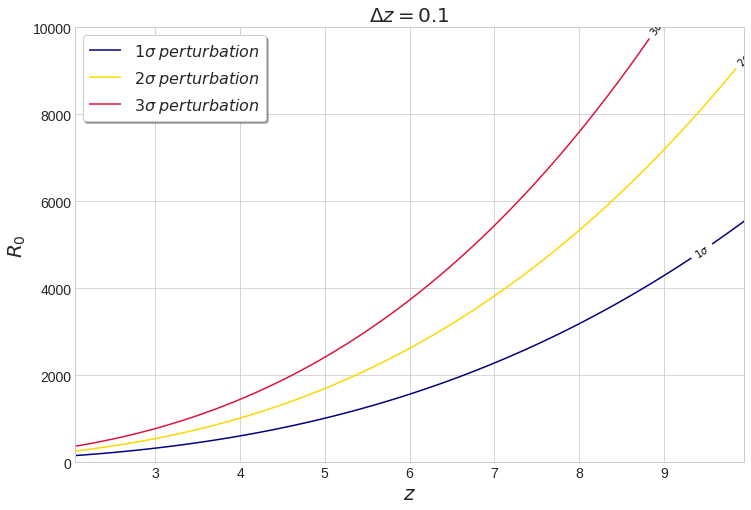

In [41]:
fig, ax = plt.subplots(figsize = [12,8])
c = ax.contour(X, Y, Z, levels=[SGWB_1sig, SGWB_2sig, SGWB_3sig], colors = ['navy','gold','crimson']);
fmt = {}
strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(c.levels, strs):
    fmt[l] = s
ax.clabel(c, inline=True, fmt = fmt, fontsize=10, colors = 'black')
lines = [c.collections[0],c.collections[1], c.collections[2]]
labels = [r'$1\sigma \; perturbation$', r'$2\sigma \; perturbation$', r'$3\sigma \; perturbation$']
ax.set_xlabel(r'$z$', fontsize = 20)
ax.set_ylabel(r'$R_0$', fontsize = 20)
ax.set_title(r'$\Delta z = 0.1$', fontsize = 20)
plt.legend(lines, labels, loc=2, frameon = True, fancybox = True, shadow = True)
fig.savefig('SGWBFOMvsSigmas.png', dpi = 500)